In [1]:
# Import useful libraries
import pandas as pd, json, pydeck as pdk, pickle, seaborn as sns, utils
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# **Generalization**

The project aim is to create a Machine Learning model capable of detecting the dates when a crop field has been manured, using satellite data. <br>
Now is the turn to see how much the *best model*, obtained in the [ML models notebook](../3-ml-models/notebook.ipynb), can generalize our classification problem. More precisely, the purpose is to see how it performs in detecting when crop fields have been manured in a different country from the trained one.

**N.B:** Since using radar indexes is useless (as seen), they won't be considered. <br>
The dataset used to test generalization contains features that have been extracted using the [features-extraction notebook](../1-features-extraction/notebook.ipynb) (all crop fields details can be found in the [other-fields JSON file](../../Datasets/other/other-fields.json)).

In [2]:
s2_df =  pd.read_csv('../../Datasets/other/other-fields-s2-features-extracted.gz', compression='gzip')

## **Show crop fields locations on Earth-map**

The objective is just visualizing where our crops, used to test the generalization capability of the final obtained model, are geographically located. This can provide several benefits, including:
* **Spatial context:** it can provide a spatial context that makes it easier to understand the geographic distribution of the fields. This can be especially useful for people who are not familiar with the area or the crops being considered
* **Data exploration:** it can make it easier to explore the data contained in the JSON file. Users can zoom in and out, pan, and filter the data to focus on specific areas or types of crops
* **Data validation:** it can help validate the data contained in the JSON file. Users can visually confirm that the crop fields are located in the correct locations, and identify any potential errors or discrepancies in the data
* **Communication:** it can be a powerful way to communicate data to others. Users can share the map with stakeholders or the public to help them understand the geographic distribution of crop fields

In [3]:
# Load JSON data from file
with open('../../Datasets/other/other-fields.json') as f:
    data = json.load(f)

# Create DataFrame with properties excluding 'manure_dates' column
fields_df = pd.DataFrame([{k:v for k,v in f['properties'].items() if k!='manure_dates'} for f in data['features']])

# Add column with coordinates for each field
fields_df['polygon_coordinates'] = [[tuple(c) for c in p] for f in data['features'] for p in f['geometry']['coordinates']]

layer = pdk.Layer(
    'PolygonLayer',
    data=fields_df,
    get_polygon='polygon_coordinates',
    get_fill_color=[255, 255, 0, 100],
    get_line_color=[255, 255, 0, 100],
    stroked=True,
    filled=True,
    lineWidthMinPixels=3,
    pickable=True,
    auto_highlight=True,
)

# Define the initial view state of the map
view_state = pdk.ViewState(
    longitude=fields_df.polygon_coordinates[0][1][0],
    latitude=fields_df.polygon_coordinates[0][1][1] - 0.3,
    zoom=8.1
)

# Create the map with the layers and the initial view state
r = pdk.Deck(layers=layer, initial_view_state=view_state,)

# Show the map
r

{
  "initialViewState": {
    "latitude": 45.49125491695544,
    "longitude": 8.798290654179008,
    "zoom": 8.1
  },
  "layers": [
    {
      "@@type": "PolygonLayer",
      "autoHighlight": true,
      "data": [
        {
          "crop_field_name": "P-VAPR1",
          "polygon_coordinates": [
            [
              8.798287971969993,
              45.79133346681193
            ],
            [
              8.798290654179008,
              45.79125491695544
            ],
            [
              8.798438175674827,
              45.79110371552986
            ],
            [
              8.79861520146981,
              45.790899858880465
            ],
            [
              8.79870907878533,
              45.79080821665754
            ],
            [
              8.798768087383658,
              45.790778292633746
            ],
            [
              8.798821731563956,
              45.7907670711207
            ],
            [
              8.798911585565955,
              45.79078109801165
            ],
            [
              8.799067153688819,
              45.79083720554024
            ],
            [
              8.7990819058384,
              45.790869934905885
            ],
            [
              8.799052401539237,
              45.79093913407277
            ],
            [
              8.798974617477805,
              45.791027035593274
            ],
            [
              8.798899515625388,
              45.79109062384085
            ],
            [
              8.798864646908195,
              45.7911298988987
            ],
            [
              8.798799861005433,
              45.791195357266915
            ],
            [
              8.798756945661195,
              45.79125707508655
            ],
            [
              8.79873280578006,
              45.791318792837856
            ],
            [
              8.798751581243165,
              45.791389861678944
            ],
            [
              8.798722076944001,
              45.79145344951257
            ],
            [
              8.79860674195636,
              45.791500205226306
            ],
            [
              8.798472631505616,
              45.791464670887436
            ],
            [
              8.798362660936005,
              45.79139921283551
            ],
            [
              8.798287971969993,
              45.79133346681193
            ]
          ]
        },
        {
          "crop_field_name": "P-VAPR2",
          "polygon_coordinates": [
            [
              8.658803437240303,
              45.85842753378426
            ],
            [
              8.659361336715401,
              45.858760033348474
            ],
            [
              8.65914675999421,
              45.85884595987881
            ],
            [
              8.659066293834075,
              45.85893375417656
            ],
            [
              8.659018013961495,
              45.85903649214644
            ],
            [
              8.658929501236464,
              45.85910373860183
            ],
            [
              8.658808801658333,
              45.85923823148284
            ],
            [
              8.658572767265023,
              45.85933536497635
            ],
            [
              8.658411834724129,
              45.859275590538886
            ],
            [
              8.65825358439225,
              45.85939700729767
            ],
            [
              8.658241514680979,
              45.859448375798564
            ],
            [
              8.65814897824067,
              45.85969401025168
            ],
            [
              8.657719824798287,
              45.859436234193865
            ],
            [
              8.657998774535836,
              45.8592083442199
            ],
            [
              8.658191893584908,
              45.85896924553828
            ],
            [
      

## **Modify original DataFrame**

The purpose of building this `DataFrame`, and modifying the [original one](../../Datasets/other/other-fields-s2-features-extracted.gz), is to ensure that its data structure will be compliant with the one used to train the Machine Learning model.

By doing so, it can be ensured that the data is consistent and that the model can make predictions. This will help to check whether the research objectives have been achieved and ensure that the model is optimized for the classification task at hand.

In [4]:
# Sentinel-2
s2_df_mod = utils.get_modified_df(s2_df, sentinel=2)
s2_df_mod

,crop_field_name,consequent_s2_acquisitions,B1,B2,B3,B4,B5,B6,B7,B8,...,CARI2,MCARI,MCARI1,MCARI2,BSI,GLI,ALTERATION,SDI,manure_dates,y
0,P-PVPR,"[2022-02-20, 2022-02-25]",-7861.017493,-6927.431851,-6130.450437,-5886.305758,-5448.576895,-4412.897230,-4103.556122,-4059.272595,...,286.831577,423.258445,2250.062055,0.390796,-19894.776295,0.036314,0.085591,-1202.978863,['2022-03-31'],0.0
1,P-PVPR,"[2022-02-25, 2022-03-07]",43.822522,32.149781,23.640306,46.419825,77.381924,93.658892,110.785714,207.320700,...,633.773065,29.908810,196.161210,0.009070,283.278732,-0.004427,0.008213,229.278426,['2022-03-31'],0.0
2,P-PVPR,"[2022-03-07, 2022-03-22]",-6.842201,-104.489431,-40.489796,-70.386662,33.913630,200.918732,217.755102,240.096210,...,-10.261910,149.834731,493.734446,0.048249,-123.634453,0.013177,0.034230,468.017493,['2022-03-31'],0.0
3,P-PVPR,"[2022-03-22, 2022-03-27]",595.951531,471.065233,382.447522,362.365889,116.827259,-197.631560,-242.867347,-367.212099,...,-224.856223,-317.107955,-1019.264956,-0.118277,18.945749,-0.013478,-0.109009,-240.495627,['2022-03-31'],0.0
4,P-PVPR,"[2022-03-27, 2022-04-11]",-500.664723,-307.916910,-182.420190,108.091837,-36.178571,-366.692784,-396.944242,-378.666910,...,2694.004966,-219.587822,-1154.131356,-0.165820,381.870826,-0.017904,-0.052983,-1365.884475,['2022-03-31'],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,P-VAPR2,"[2023-03-20, 2023-03-22]",84.638202,139.676404,76.229213,58.703371,53.838202,102.067416,154.734831,182.314607,...,74.797560,-6.549324,205.340494,0.006655,519.930317,-0.009576,-0.009162,68.393258,['2022-02-24'],0.0
186,P-VAPR2,"[2023-03-22, 2023-03-25]",45.471910,-3.775281,43.161798,-5.925843,34.458427,295.029213,326.332584,339.148315,...,-154.042887,66.947233,573.483506,0.038466,216.334470,0.014575,0.007173,431.476404,['2022-02-24'],0.0
187,P-VAPR2,"[2023-03-25, 2023-03-27]",-211.649438,-228.150562,-156.865169,-139.058427,-114.204494,-172.276404,-173.208989,-146.182022,...,-281.202488,44.651980,-38.036494,0.015346,-593.536598,0.014923,0.011755,-71.465169,['2022-02-24'],0.0
188,P-VAPR2,"[2023-03-27, 2023-04-01]",4962.676404,4355.898876,4079.743820,4213.865169,4047.966292,2736.856180,2292.624719,2098.714607,...,15981.407345,-314.803671,-3255.046112,-0.529465,13417.202006,-0.064503,-0.344450,-1146.993258,['2022-02-24'],0.0


## **Test the best obtained model, on new unseen data**

The primary objective is to conduct a comprehensive test to evaluate the generalization capability of the best obtained model, specifically for crops located in Italy. 

This will help to determine the model's ability to generalize and adapt to different crops and environmental conditions, which is a crucial step in this research as it will enable to identify potential shortcomings.

### Load the model and the feature scaler

In the previous stage, the best model configuration was stored in memory.
Therefore, there is the need to retrieve the stored model and scaler (**if used**), to ensure that the indexes are transformed correctly and the model can make accurate predictions. 

This is an important step, as it will enable us to reuse the best model configuration and avoid the need to retrain the model from scratch, saving us time and resources.

In [5]:
model = pickle.load(open('../3-ml-models/saved-config/model.pkl', 'rb'))
scaler = pickle.load(open('../3-ml-models/saved-config/scaler.pkl', 'rb'))

### Select the useful indexes, and the column to be predicted

It is quite obvious that the selected features should be exactly the same as the ones used by the best model for making predictions.

In [6]:
X = s2_df_mod[['EOMI3', 'SCI', 'EOMI1', 'SDI']]
y = s2_df_mod.iloc[:, -1]

### Show performances

#### Confusion matrix
A confusion matrix is a comprehensive way to gain more insight about a [classifier's performance](https://www.v7labs.com/blog/confusion-matrix-guide). <br>
In this case, since our classes are just two, the confusion matrix is binary. A binary confusion matrix is a specific table layout that allows the visualization of the performance of a binary classification algorithm, which is a supervised learning algorithm that classifies the data into two classes. 

It is a $[2,2]$ matrix that summarizes the performance of the algorithm by counting the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The four outcomes can be formulated in a $[2,2]$ confusion matrix, where the rows represent the actual class and the columns represent the predicted class. 

The displacement of TP, TN, FN and FP in the later on printed binary confusion matrix ([sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) is the following one:
$$\begin{bmatrix}
TN & FP\\
FN & TP
\end{bmatrix}$$

The confusion matrix allows the calculation of accuracy, precision, recall, or F1-score. Furthermore, it can also be used to calculate the sensitivity, specificity, and positive and negative predictive values of the algorithm. All of them are useful metrics in order to evaluate the goodness of the considered model.

In [7]:
y_pred = model.predict(scaler.transform(X) if scaler != None else X)

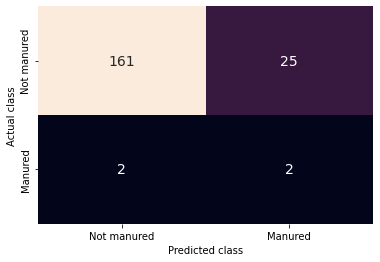

In [8]:
# Show confusion matrix
sns.heatmap(confusion_matrix(y, y_pred),
           annot=True,
           fmt='d',
           cbar=False,
           xticklabels=['Not manured', 'Manured'], yticklabels=['Not manured', 'Manured'],
           annot_kws={
                'fontsize': 14
}).set(xlabel='Predicted class', ylabel='Actual class');

#### Mean accuracy, precision, recall and f1-score

The numeric value under each performance metric represents the weighted average of the metric for the two classes: 0 (not fertilized) and 1 (fertilized). That's why using the term *"mean"* before the metric's name. <br>
Read the [sklearn.metrics documentation](https://scikit-learn.org/stable/modules/model_evaluation.html) if needed.

In [9]:
# Create a DataFrame containing performance metrics results
pd.DataFrame.from_dict({
    'Mean Accuracy': [round(accuracy_score(y, y_pred), 2)],
    'Mean Precision': [round(precision_score(y, y_pred, average='weighted', zero_division=0), 2)],
    'Mean Recall': [round(recall_score(y, y_pred, average='weighted', zero_division=0), 2)],
    'Mean F1': [round(f1_score(y, y_pred, average='weighted', zero_division=0), 2)]
})

,Mean Accuracy,Mean Precision,Mean Recall,Mean F1
0,0.86,0.97,0.86,0.91


### Investigation: why errors?

The objective of this investigation is to understand why (and where) the model is making errors in this generalization classification task, with visual tools.

#### False negatives (and True positives)

In [10]:
s2_df_mod2 = pd.concat([s2_df_mod, pd.DataFrame(y_pred).rename(columns={0:'y_pred'})], axis=1)
s2_df_mod2[(s2_df_mod2['y']==1)][['crop_field_name', 'consequent_s2_acquisitions', 'EOMI3', 'SCI', 'EOMI1', 'SDI', 'y', 'y_pred']].set_index('crop_field_name')

,consequent_s2_acquisitions,EOMI3,SCI,EOMI1,SDI,y,y_pred
crop_field_name,,,,,,,
P-PVPR,"[2022-03-27, 2022-04-11]",0.163923,0.186659,0.178436,-1365.884475,1.0,1.0
P-PVTG,"[2023-03-22, 2023-03-27]",0.085630,0.120659,0.109836,-358.966394,1.0,1.0
P-VAPR1,"[2022-03-22, 2022-04-16]",0.044968,0.025541,0.019685,-531.916667,1.0,0.0
P-VAPR2,"[2022-02-23, 2022-02-25]",-0.012166,-0.011576,-0.013759,13.179775,1.0,0.0


#### False positives (and True negatives)

In [11]:
pd.concat([s2_df_mod2[(s2_df_mod2['y']==0) & (s2_df_mod2['y_pred']==0)].sample(n=10)[['crop_field_name', 'consequent_s2_acquisitions', 'EOMI3', 'SCI', 'EOMI1', 'SDI', 'y', 'y_pred']], s2_df_mod2[(s2_df_mod2['y']==0) & (s2_df_mod2['y_pred']==1)].sample(n=10)[['crop_field_name', 'consequent_s2_acquisitions', 'EOMI3', 'SCI', 'EOMI1', 'SDI', 'y', 'y_pred']]]).sort_values(by=['crop_field_name', 'consequent_s2_acquisitions']).set_index('crop_field_name')

,consequent_s2_acquisitions,EOMI3,SCI,EOMI1,SDI,y,y_pred
crop_field_name,,,,,,,
P-PVPR,"[2022-02-20, 2022-02-25]",0.171095,0.061607,0.044393,-1202.978863,0.0,1.0
P-PVPR,"[2022-06-20, 2022-06-25]",-0.017883,-0.019454,-0.017053,81.752915,0.0,0.0
P-PVPR,"[2022-08-09, 2022-08-24]",0.076443,0.082403,0.090576,-636.343659,0.0,1.0
P-PVPR,"[2022-08-29, 2022-09-08]",-0.017549,-0.023676,-0.021420,243.853499,0.0,0.0
P-PVPR,"[2022-09-18, 2022-10-08]",0.090903,0.144264,0.121598,-1306.539359,0.0,1.0
P-PVTG,"[2022-03-27, 2022-04-11]",0.145196,0.184286,0.158085,-1374.353296,0.0,1.0
P-PVTG,"[2022-04-11, 2022-04-16]",0.037659,0.031167,0.031989,-519.757432,0.0,0.0
P-PVTG,"[2022-05-11, 2022-05-16]",-0.005764,-0.024688,-0.027343,226.338216,0.0,0.0
P-PVTG,"[2022-05-16, 2022-06-10]",-0.223367,-0.296732,-0.286697,2113.467471,0.0,1.0


### Trends

By visually examining the trends of the indexes shown later on (and/or referring to the two tables above for false positives and false negatives), it is easy to understand where and why the model is making misclassification errors. A **possible reason** is that there are times when features change significantly in value even when manure has not been applied, which can lead our model to make mistakes.

In conclusion, although the classification problem related to manure application is not as simple as it seems to be, the developed model should not be disregarded. It provides a valuable foundation for developing fast and low-price tools to monitor manure application in crop fields (by analyzing satellites index time-series). This research represents an attempt to ensure compliance with environmental regulations, such as the [EU Nitrates Directives](https://environment.ec.europa.eu/topics/water/nitrates_en), and **there is still space for further improvements**.

**Observations**: Shown features values are not the plain original ones, but the scaled between $[-1, 1]$. <br>
The vertical dashed lines have been added in order to highlight the acquisitions right before and after (or same day) manure application, which is our Region of Interest (namely ***RoI***).

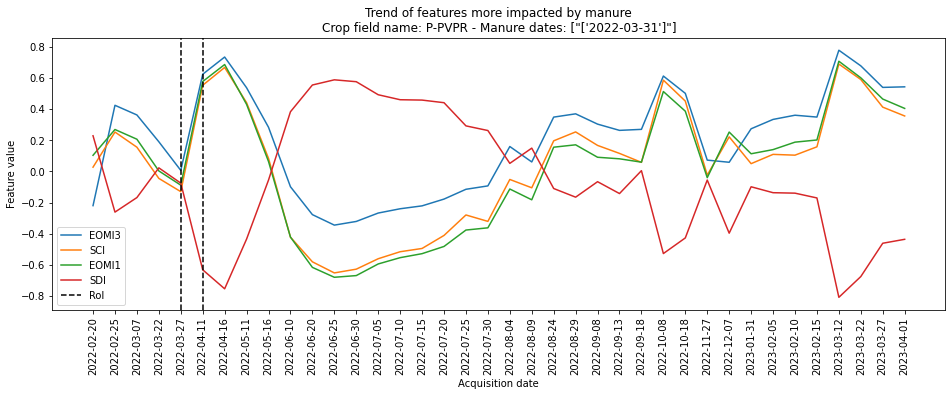

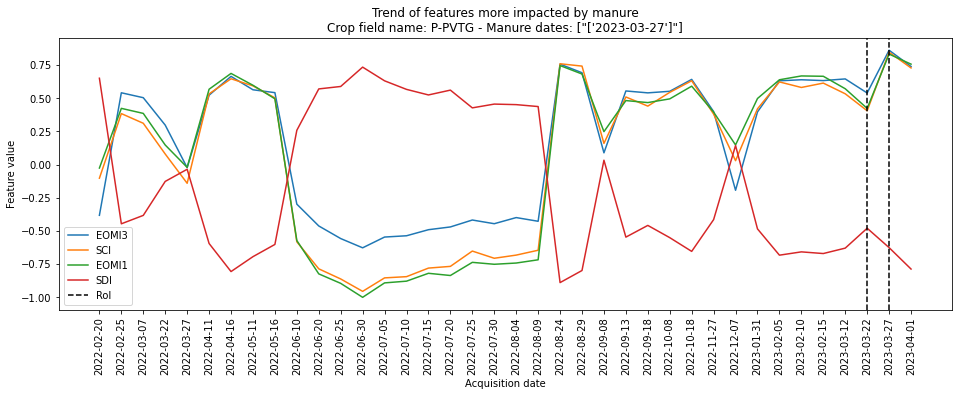

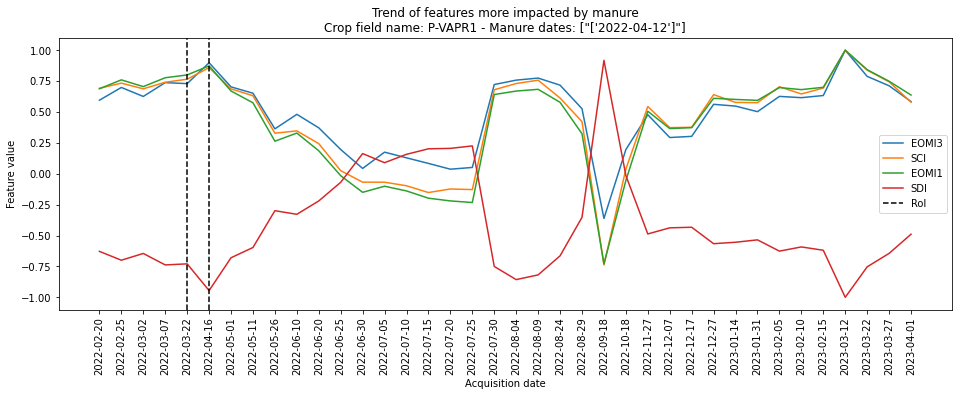

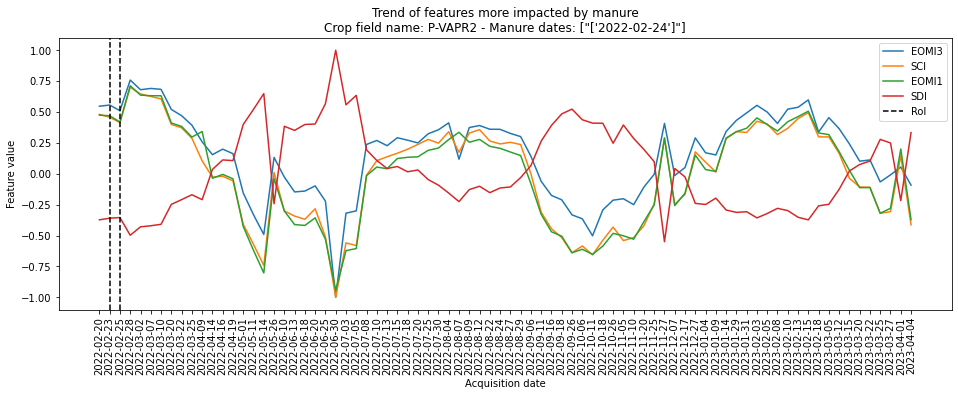

In [12]:
# Sentinel-2
s2_df_norm= utils.get_normalized_df(s2_df, method="min-max")
utils.display_features_trends(s2_df_norm, (0, 4), ['EOMI3', 'SCI', 'EOMI1', 'SDI'], (0, 4), 2)